# **Stable Diffusion**

**Source:** [Stable_diffusion_Example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)


Stable Diffusion model was created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It is a text-to-image latent diffusion model and trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database.

This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. The model used here includes 860M UNet and 123M text encoder making it a lightweight version to try and expoeriment with.

More information related to the model can be found here: [model card](https://huggingface.co/CompVis/stable-diffusion).

We will be using 🤗 Hugging Face [Diffusers library](https://github.com/huggingface/diffusers). for trying out the Stable Diffusion model.

Let's get started!

In [ ]:
!nvidia-smi

Fri Oct  6 18:36:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Using Stable Diffusion model

We are just trying out the stable diffusion functions. Here, we will pass a prompt and use it to obtain the text to image inference. This can be done using just a few lines of code as below:

## Setting up the environment and downloading the packages

For reproducing this please connect to `T4GPU runtime` from the `change Runtime type`.
Next run the follwing cell to install the `diffusers` as well `scipy` We need the `ftfy` and `transformer`, `accelerate` for faster loading.

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.2 MB/s eta 0:00:00


### Stable Diffusion Pipeline

First, we load the pre-trained weights  corresponding to all the components in the model. Here we are using the Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)). You can try other variants too. This variant provides a 512 x 512 image.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.

For the ease of experimentation, the weights are loaded from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16). Further, we need to tell `diffusers` to expect weights of the same precision by passing `torch_dtype=torch.float16`.
For highest possible precision, remove `torch_dtype=torch.float16` but this would cost a higher memory usage.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

safety_checker/pytorch_model.fp16.safetensors not found


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


For faster inference we will use the GPU now

In [ ]:
pipe = pipe.to("cuda")

And we are ready to generate images:

  0%|          | 0/50 [00:00<?, ?it/s]

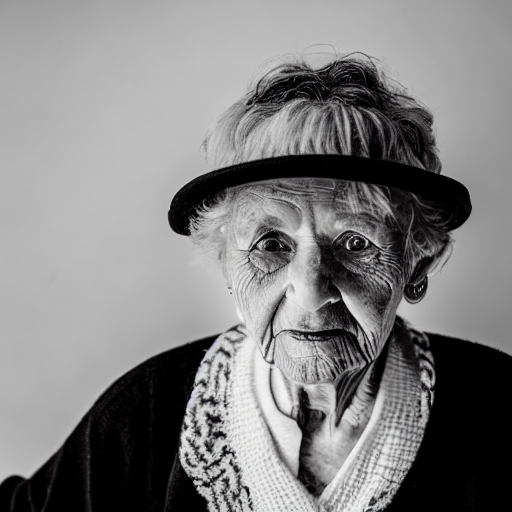

In [ ]:
prompt = "DSLR image of an elderly woman in black and white"
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
image.save(f"elderly lady.pdf")

# or if you're in a google colab you can directly display it with
image

Let us try displaying a grid of images to understand the different ways the model generates the image

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
num_images = 3
prompt = ["DSLR image of an elderly woman in black and white"]*num_images
images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

grid.save("grid.pdf")

  0%|          | 0/50 [00:00<?, ?it/s]

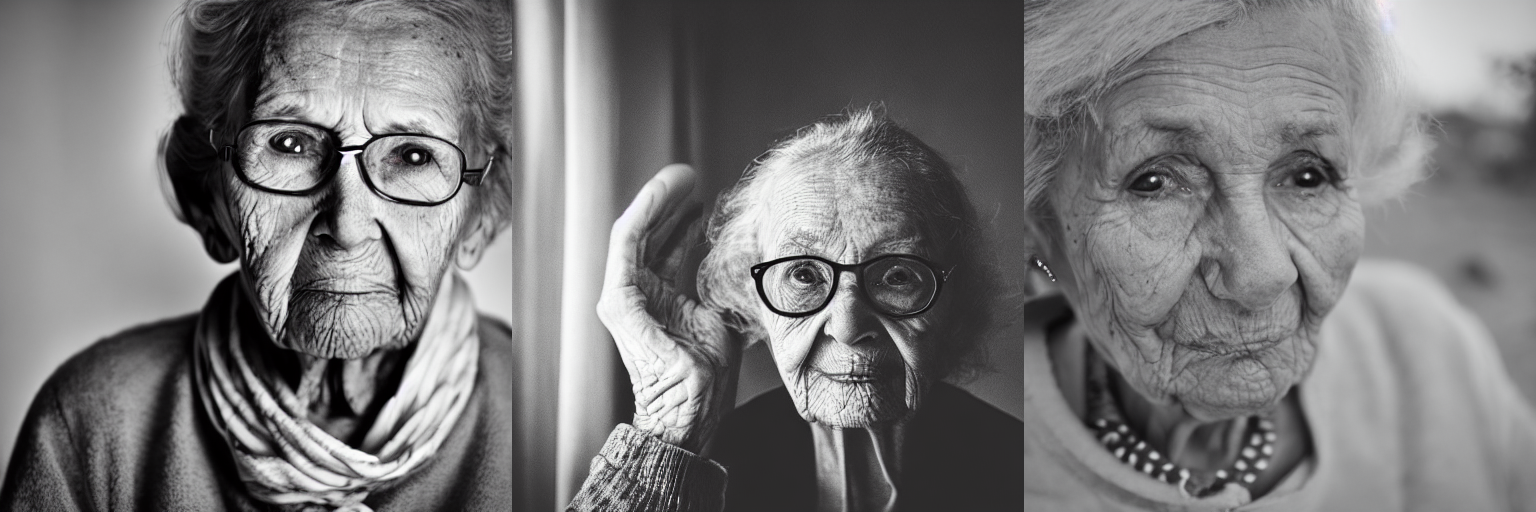

In [ ]:
grid